# Tree based models
In this notebook, we will use bagging, boosting and random forest to try to improve the best baseline model - LogReg


In [1]:
import numpy as np
import pandas as pd
import pyarrow.parquet as pq #source: https://arrow.apache.org/docs/python/parquet.html
from sklearn.model_selection import train_test_split #source: KNN-Creditrisk
from sklearn.model_selection import GridSearchCV #source: treeModels.ipynb
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier

df_base = pd.read_parquet(r"C:\school\AImethods\Assignment_1\bjj\datasets\computed\metacritic_sales_tier_modelling.parquet")

### Data preparation 
To use the tree based models, we first create a train/validation and testset. Let's do this the professional way and do this with *object oriented programming*.  (Source: KNN-Creditrisk) 

#### Creating the train, test, and validation splits (source: KNN notebook)

- **We split the dataset into train, validation, and test**

- We will set test aside, which will be used to evaluate the final performance of the model. Then we will use train and validation to fit the actual model.

- Note: We use stratisfied sampling since we want to make sure that the distribution of sales tiers is equal in train/validate/test

In [2]:
pd.set_option('display.max_columns', None) #it compresses the view, so this neat trick helps :)
df_base.head() #quick look at the final modelling dataset

,movie_id,metascore,userscore,runtime,production_budget_log,theatre_count_log,release_year,genre_list,genre_Action,genre_Adult,genre_Adventure,genre_Animation,genre_Biography,genre_Black Comedy,genre_Comedy,genre_Concert/Performance,genre_Crime,genre_Documentary,genre_Drama,genre_Educational,genre_Family,genre_Fantasy,genre_History,genre_Horror,genre_Multiple Genres,genre_Music,genre_Musical,genre_Mystery,genre_News,genre_Reality,genre_Romance,genre_Romantic Comedy,genre_Sci-Fi,genre_Short,genre_Sport,genre_Thriller,genre_Thriller/Suspense,genre_Unknown,genre_War,genre_Western,rating_missing,rating_clean,rating_G,rating_NC-17,rating_Not Rated,rating_PG,rating_PG-13,rating_R,season_Fall,season_Spring,season_Summer,season_Winter,summer_release,holiday_release,user_embed_1,user_embed_2,user_embed_3,user_embed_4,user_embed_5,user_embed_6,user_embed_7,user_embed_8,user_embed_9,user_embed_10,expert_embed_1,expert_embed_2,expert_embed_3,expert_embed_4,expert_embed_5,expert_embed_6,expert_embed_7,expert_embed_8,expert_embed_9,expert_embed_10,sales_tier_encoded
0,6305dc82622a,59.0,6.7,129.0,16.993564,4.262680,2000.0,"[""Drama""]",0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,Not Rated,False,False,True,False,False,False,False,False,False,True,0,0,4.791063,0.105657,-0.019576,-0.004482,0.081379,0.002436,0.027291,0.004146,0.047220,-0.040455,5.248415,-0.013454,-0.028619,0.025156,-0.031859,-0.024816,-0.012283,-0.021413,0.034195,-0.025543,0
1,662bc1e3cf57,31.0,8.7,109.0,17.216708,7.797291,2001.0,"[""Drama"",""Thriller""]",0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,PG-13,False,False,False,False,True,False,False,False,False,True,0,0,-22.518179,7.926952,-4.374372,-5.471427,4.792280,-5.970364,1.263540,-1.506532,4.172362,4.004245,-18.119719,-5.644859,6.622465,5.285645,-4.129042,-17.439384,-4.432830,6.081197,-1.913313,3.629471,2
2,dfc233d7a2f9,59.0,6.7,104.0,16.213406,7.788212,2002.0,"[""Drama""]",0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,Not Rated,False,False,True,False,False,False,False,False,False,True,0,0,4.791063,0.105657,-0.019576,-0.004482,0.081379,0.002436,0.027291,0.004146,0.047220,-0.040455,5.248415,-0.013454,-0.028619,0.025156,-0.031859,-0.024816,-0.012283,-0.021413,0.034195,-0.025543,2
3,ed1dd3e75880,41.0,6.4,104.0,16.906553,7.812378,2008.0,"[""Thriller"",""Comedy"",""Romance"",""Crime""]",0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,PG-13,False,False,False,False,True,False,False,False,False,True,0,0,-23.572487,2.176041,2.813654,1.120385,-7.183623,0.716902,6.641965,4.013510,7.728705,1.252990,-19.683950,-6.086373,-7.251342,6.611788,1.355806,1.178939,-1.492724,4.369090,3.527283,1.824804,2
4,8e3d5b8714f4,30.0,5.1,95.0,16.118096,7.589842,2008.0,"[""Fantasy"",""Comedy"",""Romance""]",0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,PG-13,False,False,False,False,True,False,False,False,False,True,0,0,-19.584745,-9.910595,-4.104996,7.199965,7.064362,-3.296383,5.574745,4.356566,0.314410,-4.770975,-22.277643,-4.169212,-3.627316,4.190808,-9.552444,-1.246047,4.286777,-1.451442,5.136322,2.053113,2


We can see here that the dataset has a bunch of different characteristics that we can and cannot use. 
1. The dataset still has string data instead of numeric 
2. The dataset has both features and embeddings, so we can use the dataset with and without the embeddings to see if the reviews have any impact on model performance.
3. The target is encoded in three classes to we have to use stratisfied sampling

In the following codeblock, we use object oriented programming to 

In [3]:
# First we initialize the splitter, which is basically the settings of the splitter 
# We want to get 80% of the data for training, and 20% for testing
# To do this, we first set the fraction for training to 0.64 since 0.8*0.8= 0.64 (80% of the 80% for training)
# Then we create the validation fraction which is 20% of the initial 80% training dat, so 1-0.64 = 0.16
# the "rest" of the data is the testset 
class TrainTestSplitter: 
    def __init__(self, train_frac=0.64, val_frac=0.16, seed=1234): #initialize the object, with 64% training data, 16% validation
        self.train_frac = train_frac # Use the self statement to let the function remember the settings
        self.val_frac = val_frac 
        self.seed = seed #Make sure that the first and the second split use the same starting point

    def split_data(self, df, target_col):
        """
        Split the data into train, validation and test sets using stratisfied sampling
        The split first splits the test set from the full dataframe and then splits the remaining data into train and validation
        
        :param self: provides the settings and stores the results
        :param df: The full modelling dataframe
        :param target_col: The column used for stratification

        Returns:
        train_set, validation_set, test_set
        """
          
        print(f"Splitting data based on target: {target_col}...") #the function prints some text and the column that we do stratification on
        
        # Calculate the fraction that is not the trainset or validation set to find the testset
        test_frac = 1.0 - (self.train_frac + self.val_frac)
        
        # First split is the training dataset
        # 'temp_df' contains both the train and validation set for a moment
        temp_df, self.test_set = train_test_split(
            df, 
            test_size=test_frac, 
            random_state=self.seed, 
            stratify=df[target_col]
        )
        
        # 3. Calculate the relative size for the second split
        relative_val_size = self.val_frac / (self.train_frac + self.val_frac)
        
        # 4. Second Split: Separate Train and Validation from temp_df
        self.train_set, self.validation_set = train_test_split(
            temp_df, 
            test_size=relative_val_size, 
            random_state=self.seed, 
            stratify=temp_df[target_col]
        )
        
        # 5. Clean up the indexes (so they start at 0, 1, 2...)
        self.train_set = self.train_set.reset_index(drop=True)
        self.validation_set = self.validation_set.reset_index(drop=True)
        self.test_set = self.test_set.reset_index(drop=True)

        print(f"Split completed. Train: {len(self.train_set)}, Val: {len(self.validation_set)}, Test: {len(self.test_set)}")
        
        return self.train_set, self.validation_set, self.test_set

Now we actually create a splitter object

In [4]:
# 1. Create the 'splitter' object from the class
# We will use 64% for training and 16% for validation
splitter = TrainTestSplitter(train_frac=0.64, val_frac=0.16, seed=42)

# 2. We run the split_data method and tell it the target is 'sales_tier_encoded'
train, val, test = splitter.split_data(df_base, target_col='sales_tier_encoded')

# 3. Double checking a specific tier to see if stratification worked
print("\nProportion of tiers in Training Set:")
print(train['sales_tier_encoded'].value_counts(normalize=True))

print("\nProportion of tiers in Test Set:")
print(test['sales_tier_encoded'].value_counts(normalize=True))

Splitting data based on target: sales_tier_encoded...
Split completed. Train: 13932, Val: 3484, Test: 4354

Proportion of tiers in Training Set:
sales_tier_encoded
1    0.340009
2    0.330032
0    0.329960
Name: proportion, dtype: float64

Proportion of tiers in Test Set:
sales_tier_encoded
1    0.339917
2    0.330041
0    0.330041
Name: proportion, dtype: float64


The split worked perfectly, both the training and the testset have equal propotions of all the sales tiers. 

Now we create the dataframes that hold the data we want to use for modelling by separating the target from the features:
- X_train = All the data from the training set without the target
- Y_train = The target data 

- X_val = All the data from the validation set without the target
- Y_val = The target data in the validation set

- X_test = All the data from the validation set without the target
- Y_test = The target data in the test set

NOTE: Tree based models only work with numeric data. We will therefore drop the data that has non-numeric data


In [5]:
pd.set_option('display.max_rows', None) #it compresses the view, very anoying actually
df_base.dtypes #print the datatypes to see which ones dont work for the bagged trees

movie_id                      object
metascore                    float64
userscore                    float64
runtime                      float64
production_budget_log        float64
theatre_count_log            float64
release_year                 float64
genre_list                    object
genre_Action                   int64
genre_Adult                    int64
genre_Adventure                int64
genre_Animation                int64
genre_Biography                int64
genre_Black Comedy             int64
genre_Comedy                   int64
genre_Concert/Performance      int64
genre_Crime                    int64
genre_Documentary              int64
genre_Drama                    int64
genre_Educational              int64
genre_Family                   int64
genre_Fantasy                  int64
genre_History                  int64
genre_Horror                   int64
genre_Multiple Genres          int64
genre_Music                    int64
genre_Musical                  int64
g

Now we create the target and the features. A few important notes here: 
1. The object datatypes will be removed. e.g. the Rating_clean and genre_list does not make any sense since they have been on hot encoded and the id has no predictive power anyway
2. The boolean types are converted to numbers

In [6]:
# 1. Create the target (y)
y_train = train['sales_tier_encoded']
y_validation = val['sales_tier_encoded']

# 2. Create the features (X)
# We exclude 'object' to remove movie_id, genre_list, and rating_clean automatically
X_train = train.drop(columns=['sales_tier_encoded']).select_dtypes(exclude=['object'])
X_validation = val.drop(columns=['sales_tier_encoded']).select_dtypes(exclude=['object'])

# 3. Convert booleans (true/false) to numbers (1/0)
# This makes it easier for the bagging model to calculate 
X_train = X_train.astype(float)
X_validation = X_validation.astype(float)

print(f"Success! We are using {X_train.shape[1]} features.")


Success! We are using 71 features.


In [7]:
y_test = test["sales_tier_encoded"] #The target column in the testset
X_test = test.drop(columns=["sales_tier_encoded"]).select_dtypes(exclude=["object"]).astype(float) # All the other data in the testset without the object data

# ensure same columns/order as training
X_test = X_test.reindex(columns=X_train.columns, fill_value=0.0)


In [8]:
X_train.head()

#sanity check

,metascore,userscore,runtime,production_budget_log,theatre_count_log,release_year,genre_Action,genre_Adult,genre_Adventure,genre_Animation,genre_Biography,genre_Black Comedy,genre_Comedy,genre_Concert/Performance,genre_Crime,genre_Documentary,genre_Drama,genre_Educational,genre_Family,genre_Fantasy,genre_History,genre_Horror,genre_Multiple Genres,genre_Music,genre_Musical,genre_Mystery,genre_News,genre_Reality,genre_Romance,genre_Romantic Comedy,genre_Sci-Fi,genre_Short,genre_Sport,genre_Thriller,genre_Thriller/Suspense,genre_Unknown,genre_War,genre_Western,rating_missing,rating_G,rating_NC-17,rating_Not Rated,rating_PG,rating_PG-13,rating_R,season_Fall,season_Spring,season_Summer,season_Winter,summer_release,holiday_release,user_embed_1,user_embed_2,user_embed_3,user_embed_4,user_embed_5,user_embed_6,user_embed_7,user_embed_8,user_embed_9,user_embed_10,expert_embed_1,expert_embed_2,expert_embed_3,expert_embed_4,expert_embed_5,expert_embed_6,expert_embed_7,expert_embed_8,expert_embed_9,expert_embed_10
0,50.0,6.9,90.0,16.993564,4.26268,2017.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,-22.072214,-3.350949,2.071532,8.362472,9.307377,3.082520,1.040087,-0.247562,-0.797200,-4.038525,-20.344713,5.514405,-6.495228,2.690563,-5.935856,-2.313581,-1.974514,-1.398360,1.969382,-3.230158
1,59.0,6.7,96.0,16.993564,4.26268,2021.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,4.791063,0.105657,-0.019576,-0.004482,0.081379,0.002436,0.027291,0.004146,0.047220,-0.040455,5.248415,-0.013454,-0.028619,0.025156,-0.031859,-0.024816,-0.012283,-0.021413,0.034195,-0.025543
2,59.0,6.7,82.0,16.993564,4.26268,2021.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,4.791063,0.105657,-0.019576,-0.004482,0.081379,0.002436,0.027291,0.004146,0.047220,-0.040455,5.248415,-0.013454,-0.028619,0.025156,-0.031859,-0.024816,-0.012283,-0.021413,0.034195,-0.025543
3,59.0,6.7,90.0,16.993564,4.26268,2015.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,4.791063,0.105657,-0.019576,-0.004482,0.081379,0.002436,0.027291,0.004146,0.047220,-0.040455,5.248415,-0.013454,-0.028619,0.025156,-0.031859,-0.024816,-0.012283,-0.021413,0.034195,-0.025543
4,56.0,8.0,99.0,16.993564,4.26268,2020.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,-19.036177,-3.183167,-2.557212,-1.681025,12.416853,-9.977543,-0.942114,-2.781208,2.153989,0.649213,-20.343374,0.868960,-5.471694,2.868397,-2.174418,-3.040885,-1.008885,-6.594128,-6.573283,-4.448895


# Bagged trees 
In this chapter, we build a bagged tree with hyperparameter tuning and see which features come out on top. 
- Build an initial decision tree as a baseline
- Use the bagging classifier to build 50 trees
- Use a gridsearch for hyperparameter tuning
- Check the top 20 permutated features and confusion matrix

In [9]:
# 1. Initialize the base tree 
# We use a decision tree as the individual "voter" in the crowd
base_tree = DecisionTreeClassifier(random_state=1234)

# 2. Initialize the bagging classifier
# We build 50 trees at first
bagging_model = BaggingClassifier(
    estimator=base_tree, 
    n_estimators=50, 
    random_state=1234
)

# 3. Fit the model (This is the training phase)
# The model "studies" the relationship between X features and y sales tiers
bagging_model.fit(X_train, y_train)

# 4. Make predictions on the validation set
# We use X_validation to see how well the model learned
y_pred_val = bagging_model.predict(X_validation)

# 5. Evaluate the results
val_accuracy = accuracy_score(y_validation, y_pred_val)
print(f"Validation Accuracy: {val_accuracy:.2%}")
print("\nDetailed Report:")
print(classification_report(y_validation, y_pred_val))

Validation Accuracy: 57.26%

Detailed Report:
              precision    recall  f1-score   support

           0       0.54      0.58      0.56      1150
           1       0.46      0.46      0.46      1185
           2       0.73      0.68      0.70      1149

    accuracy                           0.57      3484
   macro avg       0.58      0.57      0.58      3484
weighted avg       0.58      0.57      0.57      3484



#### Model interpretation: initial bagging results
Our first model used a Bagging Classifier with 50 Decision Trees. With a baseline for random guessing at 33.3% (for three balanced classes), the model's accuracy of 57.26% shows big improvement. However, the baseline model logisticregression did almost just as good. Some interpretation:

- Tier 2: This is the model’s strongest area. A Precision of 73% suggests that the highest movie performers have very unique feature. This will probably be a high budget or maybe even very good expert reviews.

- Tier 0: The model is moderately successful here (56% F1-score). It can identify "flops" or niche movies with average reliability.

- Tier 1: This is the most difficult category. The low precision (46%) suggests that mid-tier movies often "look" like either low-tier or high-tier movies to the model.

Now we use grid search for hyperparameter tuning to find a configuration of the hyperparameters that performs the best. 

In [10]:
#Gridsearch for the bagged trees (source: treemodels.ipynb)
# hyperparameter tuning with crossvalidation of a random forest model
# 1. Define the "Grid" of settings
# The max_samples is used for BAGGED trees, in random forest we use max_features
# Base tree that will be bagged
base_tree = DecisionTreeClassifier(random_state=1234)

bagged = BaggingClassifier(
    estimator=base_tree,
    random_state=1234,
    n_jobs=-1
)

param_grid_baggedtree = {
    "n_estimators": [100, 200],
    "max_samples": [0.6, 0.8, 1.0],           # fraction of rows per tree
    "max_features": [0.6, 0.8, 1.0],          # fraction of features per tree
    "estimator__max_depth": [10, 20, None],   # goes to the DecisionTree
    "estimator__min_samples_split": [2, 5, 10]
}

grid_search_baggedtree = GridSearchCV(
    estimator=bagged,
    param_grid=param_grid_baggedtree,
    cv=3,
    scoring="accuracy",
    verbose=2,
    n_jobs=-1
)

print("Starting the search for the best hyperparameters...")
grid_search_baggedtree.fit(X_train, y_train)

best_baggedtree = grid_search_baggedtree.best_estimator_
y_pred_tuned = best_baggedtree.predict(X_validation)

print(f"\nBest settings found: {grid_search_baggedtree.best_params_}")
print(f"Tuned bagged tree accuracy: {accuracy_score(y_validation, y_pred_tuned):.2%}")
print("\nDetailed tuned report:")
print(classification_report(y_validation, y_pred_tuned))




Starting the search for the best hyperparameters...
Fitting 3 folds for each of 162 candidates, totalling 486 fits

Best settings found: {'estimator__max_depth': 10, 'estimator__min_samples_split': 2, 'max_features': 0.8, 'max_samples': 1.0, 'n_estimators': 200}
Tuned bagged tree accuracy: 61.97%

Detailed tuned report:
              precision    recall  f1-score   support

           0       0.57      0.73      0.64      1150
           1       0.52      0.48      0.50      1185
           2       0.83      0.65      0.73      1149

    accuracy                           0.62      3484
   macro avg       0.64      0.62      0.62      3484
weighted avg       0.64      0.62      0.62      3484



The gridsearch took quite some time, but the accuracy of the bagged tree model is significantly higher then before. Now we fit the best baggedtree on the test and validation set and show the confusion matrix and permutated feature importance plots. 

--- FINAL TEST PERFORMANCE (trained on training and validation data) ---
Accuracy: 61.48%
              precision    recall  f1-score   support

           0       0.55      0.71      0.62      1437
           1       0.51      0.47      0.49      1480
           2       0.84      0.67      0.74      1437

    accuracy                           0.61      4354
   macro avg       0.63      0.62      0.62      4354
weighted avg       0.63      0.61      0.62      4354



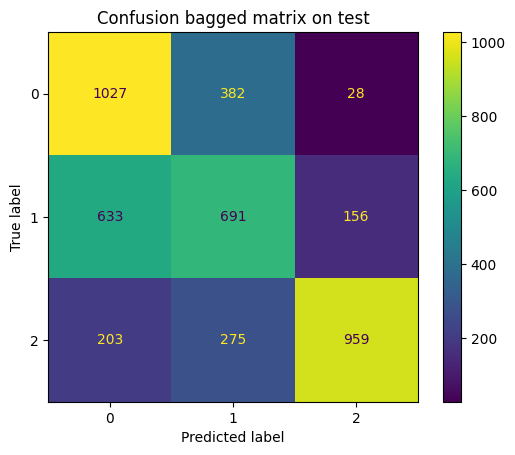

In [11]:
final_baggedmodel = best_baggedtree 

X_trainval = pd.concat([X_train, X_validation], axis=0) #add the training features to the validation features
y_trainval = pd.concat([y_train, y_validation], axis=0) #add the training target to the validation target

final_baggedmodel.fit(X_trainval, y_trainval) #fit the best model on both training and validation 

y_pred_bagged = final_baggedmodel.predict(X_test) #Let's see how wel it does

print("--- FINAL TEST PERFORMANCE (trained on training and validation data) ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred_bagged):.2%}")
print(classification_report(y_test, y_pred_bagged))

ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_bagged, values_format="d"
)
plt.title("Confusion bagged matrix on test")
plt.show()

**Conclusion** 

The best bagged tree model predicts low and high sales a lot better than medium sales. On the validation set, the model achieves an overall accuracy of 62.97%, which shows it has learned meaningful patterns, but it still makes many mistakes. When this model is fit on the validation and testset together, the performance is almost the same but a bit lower. This is standard since the testset is unseen data and not used for hypertuning. In the cofusion matrix, it can be seen that: 

- In the low sales category, the model correctly predicted 1027 from the 1437. The model predicted 382 movies that should be low tier sales as medium tier sales and 28 as high tier sales. 

- High sales are also predicted quite well! When the model predicts high sales, it is often correct. Interestingly, quite some movies that should be in high tier were actually predicted as low tier. This is a big misclassification and, given that the most important feature is by far the theatre count, could mean that some movies sold very well despite having a low theatre count. 

- The biggest weakness is medium sales: only 691 medium-sales titles are correctly classified, while many are misclassified as low sales (633) or high sales (156). This is not very surprising since these movies will probably have similar feature spaces. 

# Random forest + hyperparameter tuning

In this chapter, we build a random forest with hyperparameter tuning and see which features come out on top. 
- Build an initial random forest as a baseline
- Use the randomforest classifier to build 100 trees
- Use a gridsearch for hyperparameter tuning
- Check the top 20 built-in features and permutated features

In [12]:
# 1. Initialize the baseline random forest with standard settings
# We use 100 trees (the default) to see the baseline performance
rf_baseline = RandomForestClassifier(n_estimators=100, random_state=1234)

# 2. Fit the model
rf_baseline.fit(X_train, y_train)

# 3. Predict on the validation set
y_pred_rf = rf_baseline.predict(X_validation)

# 4. Results
rf_acc = accuracy_score(y_validation, y_pred_rf)
print(f"Random forest baseline accuracy: {rf_acc:.2%}")
print(f"Improvement over Bagging: {rf_acc - 0.5726:.2%}") # the initial bagging model accuracy
print("\nDetailed Report:")
print(classification_report(y_validation, y_pred_rf))

Random forest baseline accuracy: 56.34%
Improvement over Bagging: -0.92%

Detailed Report:
              precision    recall  f1-score   support

           0       0.54      0.55      0.55      1150
           1       0.46      0.45      0.45      1185
           2       0.69      0.70      0.70      1149

    accuracy                           0.56      3484
   macro avg       0.56      0.56      0.56      3484
weighted avg       0.56      0.56      0.56      3484



#### The random forest did not do better
The model did slightly worse then the bagged tree, interesting:

- Tier 2 is still the best tier to predict. So even when then model only sees random features they still stand out

- Tier 1 remains stuck at a 0.45 F1-score. This indicates that the "confusion" isn't necessarily because the model is looking at too many features, but perhaps because the data for Tier 1 and Tier 0 looks very similar.

Now we will use hyperparameter tuning to find the best settings for the random forest, it could very well be the case that the tree was overfitting. We will use a similar size grid as the bagged tree for consistency

In [13]:
# 1. Define the "Grid" of settings
# We are testing: 
# - More trees (200) vs fewer (100)
# - Shallow trees (10) vs Deep trees (20) vs Infinite (None)
# - How picky the tree is before making a new branch (min_samples_split)
param_grid_randomforest = {
    "n_estimators": [100, 200],                 
    "max_depth": [10, 20, None],
    "min_samples_split": [2, 5, 10, 20],
    "min_samples_leaf": [1, 2, 4],  
    "max_features": ["sqrt", "log2"]
}

# 2. Initialize the Grid Search
# n_jobs=-1 tells your computer to use all its "brains" (cores) to work faster
grid_search_randomforest = GridSearchCV(
    estimator=RandomForestClassifier(random_state=1234),
    param_grid=param_grid_randomforest,
    cv=3, 
    scoring='accuracy',
    verbose=2, 
    n_jobs=-1
)

# 3. Fit the search
print("Starting the search for the best hyperparameters...")
grid_search_randomforest.fit(X_train, y_train)

# 4. Extract the winner
best_rf = grid_search_randomforest.best_estimator_
y_pred_tuned = best_rf.predict(X_validation)

# 5. Final Comparison
print(f"\nBest Settings Found: {grid_search_randomforest.best_params_}")
print(f"Tuned random forest accuracy: {accuracy_score(y_validation, y_pred_tuned):.2%}")
print("\nDetailed Tuned Report:")
print(classification_report(y_validation, y_pred_tuned))

Starting the search for the best hyperparameters...
Fitting 3 folds for each of 144 candidates, totalling 432 fits

Best Settings Found: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 20, 'n_estimators': 200}
Tuned random forest accuracy: 61.71%

Detailed Tuned Report:
              precision    recall  f1-score   support

           0       0.58      0.71      0.63      1150
           1       0.51      0.47      0.49      1185
           2       0.79      0.68      0.73      1149

    accuracy                           0.62      3484
   macro avg       0.63      0.62      0.62      3484
weighted avg       0.62      0.62      0.62      3484



### Analysis of grid search:
1. The grid search found a configuration of the hyperparameters that balances the training and the generalization of the data. This results in a 5.23% increase in accuracy!

The model performed the best with 200 trees with a maximum depth to 20. Furthermore, the model required at least 10 samples to make a split, this acted as regularization, forcing the model to ignore outliers and focus on patterns.

2. The results is a typical example of the bias variance tradeoff. By limiting the depth of the trees and making sure they need more 10 samples to make a split, we reduced the model's variance. The high precision in the top tier indicates that this model is very useful for identifying potential blockbusters, even if the average performance movies are still hard to predict.

Last step: fitting both the training and validationset on the unseen data in the testset and showing the confusion matrix.



--- FINAL TEST PERFORMANCE (trained on training and validation data) ---
Accuracy: 60.93%
              precision    recall  f1-score   support

           0       0.56      0.69      0.62      1437
           1       0.51      0.46      0.48      1480
           2       0.79      0.68      0.73      1437

    accuracy                           0.61      4354
   macro avg       0.62      0.61      0.61      4354
weighted avg       0.62      0.61      0.61      4354



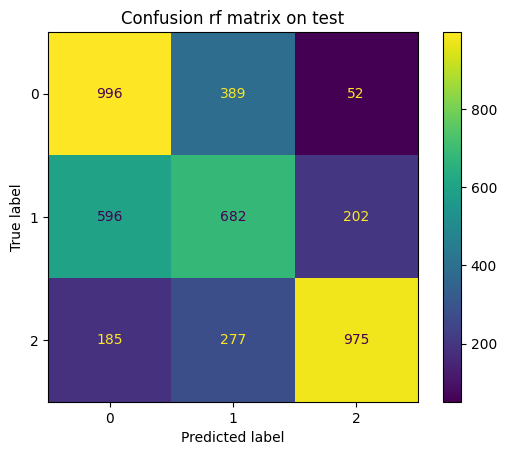

In [14]:
final_rf = best_rf 

final_rf.fit(X_trainval, y_trainval) #fit the best rf on both training and validation 

y_pred_rf = final_rf.predict(X_test) #Let's see how well it does

print("--- FINAL TEST PERFORMANCE (trained on training and validation data) ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.2%}")
print(classification_report(y_test, y_pred_rf))

ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_rf, values_format="d"
)
plt.title("Confusion rf matrix on test")
plt.show()

**Conclusion** 

The best random forest model also predicts low and high sales a lot better than medium sales. On the validation set, the model achieves an overall accuracy of 61.71%, which is slightly lower then the best bagged tree but it still makes many mistakes. On the unseen data from the testset, the model performs a bit lower again (60.93% accuracy). In the cofusion matrix, it can be seen that: 

- In the low sales category, the model correctly predicted 814 from the 1150 (see the initial bagged model output). The model predicted 295 movies that should be low tier sales as medium tier sales and 41 as high tier sales. 

- High sales are also predicted quite well. Interestingly, the best random forest performs very similar to the best bagged tree when it comes to predicting high sales. 

- The biggest weakness is again medium sales: only 553 medium-sales titles are correctly classified, while many are misclassified as low sales (295) or high sales (230).

Now, we start BOOSTING!

 # Boosted models + hyperparameter tuning
 In this chapter, we build a an ADABoost model and a XGBoost model with hyperparameter tuning. 
- Build an initial adaboost and xgBoost a baseline
- Use a gridsearch for hyperparameter tuning on the model that performed the best 
- Test the best boosted model on the test data and show confusion matrix

In [15]:
# 1. Initialize ADABoost
# We use a slightly deeper tree than the default (max_depth=3) because the data has complex embeddings
ada_model = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=3, random_state=1234),
    n_estimators=100,
    learning_rate=0.1,
    random_state=1234
)

# 2. Fit and predict
ada_model.fit(X_train, y_train)
y_pred_ada = ada_model.fit(X_train, y_train).predict(X_validation)

# 3. Results
print("--- ADABOOST PERFORMANCE ---")
print(f"Accuracy: {accuracy_score(y_validation, y_pred_ada):.2%}")
print(classification_report(y_validation, y_pred_ada))

--- ADABOOST PERFORMANCE ---
Accuracy: 58.30%
              precision    recall  f1-score   support

           0       0.61      0.51      0.56      1150
           1       0.45      0.63      0.52      1185
           2       0.81      0.61      0.70      1149

    accuracy                           0.58      3484
   macro avg       0.62      0.58      0.59      3484
weighted avg       0.62      0.58      0.59      3484



In [16]:
# 1. Initialize XGBoost
xgb_model = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    random_state=1234,
    eval_metric='mlogloss'
)

# 2. Fit and predict
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_validation)

# 3. Results
print("--- XGBOOST PERFORMANCE ---")
print(f"Accuracy: {accuracy_score(y_validation, y_pred_xgb):.2%}")
print("\nDetailed XGBoost Report:")
print(classification_report(y_validation, y_pred_xgb))

--- XGBOOST PERFORMANCE ---
Accuracy: 62.43%

Detailed XGBoost Report:
              precision    recall  f1-score   support

           0       0.58      0.72      0.64      1150
           1       0.52      0.50      0.51      1185
           2       0.81      0.67      0.73      1149

    accuracy                           0.62      3484
   macro avg       0.64      0.63      0.63      3484
weighted avg       0.64      0.62      0.63      3484



From the boosted models, the XGBoost model has the best performance. It even outperformed the random forest AFTER hyperparameter tuning. Since we are now ofcourse intensely intriqued, we will do hyperparameter tuning on the boosted model to see if we can get it even better. 

In [17]:
#GRIDSEARCH on XgBoost

xgb_model_gridsearch = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    random_state=1234,
    eval_metric='mlogloss'
)

xgb_param_grid = { #first we define the grid, it is a small one to no blow up my computer
    "n_estimators": [50, 100, 200],
    "learning_rate": [0.05, 0.1, 0.2],
    "max_depth": [3, 6, 9],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0]
}

# 3) Grid search (same style as the random forest for consistency)
xgb_grid_search = GridSearchCV(
    estimator=xgb_model_gridsearch,
    param_grid=xgb_param_grid,
    cv=5,
    scoring="accuracy",
    verbose=2,
    n_jobs=-1
)

# 4) Fit grid search on training data
xgb_grid_search.fit(X_train, y_train)

print("Best CV accuracy:", xgb_grid_search.best_score_)
print("Best params:", xgb_grid_search.best_params_)

# 5) Evaluate best model on validation set and let's see
best_xgb = xgb_grid_search.best_estimator_
y_pred_xgb = best_xgb.predict(X_validation)

print("\n--- TUNED XGBOOST PERFORMANCE (VALIDATION) ---")
print(f"Accuracy: {accuracy_score(y_validation, y_pred_xgb):.2%}")
print("\nDetailed report:")
print(classification_report(y_validation, y_pred_xgb))

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best CV accuracy: 0.6138386586682967
Best params: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 50, 'subsample': 0.8}

--- TUNED XGBOOST PERFORMANCE (VALIDATION) ---
Accuracy: 62.54%

Detailed report:
              precision    recall  f1-score   support

           0       0.58      0.71      0.64      1150
           1       0.53      0.50      0.51      1185
           2       0.81      0.67      0.73      1149

    accuracy                           0.63      3484
   macro avg       0.64      0.63      0.63      3484
weighted avg       0.64      0.63      0.63      3484



The gridsearch resulted in a very slight improvement of the model performance. Not enough to jump out of my chair, but the result is clear. The XgBoost model is the winner and will be used to fit on the testset.


--- FINAL TEST PERFORMANCE (trained on training and validation data) ---
Accuracy: 61.55%
              precision    recall  f1-score   support

           0       0.57      0.67      0.62      1437
           1       0.50      0.51      0.51      1480
           2       0.82      0.67      0.74      1437

    accuracy                           0.62      4354
   macro avg       0.63      0.62      0.62      4354
weighted avg       0.63      0.62      0.62      4354



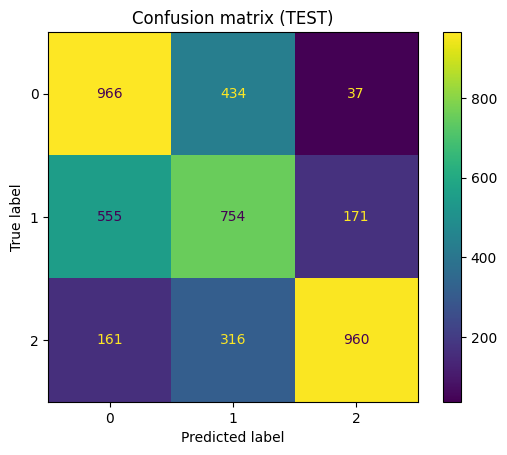

In [18]:
final_boostmodel = best_xgb  

X_trainval = pd.concat([X_train, X_validation], axis=0) #add the training features to the validation features
y_trainval = pd.concat([y_train, y_validation], axis=0) #add the training target to the validation target

final_boostmodel.fit(X_trainval, y_trainval) #fit the best model on both training and validation 

y_test_boost = final_boostmodel.predict(X_test) #Let's see how wel it does

print("--- FINAL TEST PERFORMANCE (trained on training and validation data) ---")
print(f"Accuracy: {accuracy_score(y_test, y_test_boost):.2%}")
print(classification_report(y_test, y_test_boost))

ConfusionMatrixDisplay.from_predictions(
    y_test, y_test_boost, values_format="d"
)
plt.title("Confusion matrix (TEST)")
plt.show()


**Conclusion** 

The best boosted model is the XGBoost model (61.55% accuracy). It performs a little bit better then the optimized bagged model (61.43%) and the random forest (60.93%). This model does show the same characteristics as the other models. The high performing movies are very wel predicted (82%!), the low performing movies are also fairly well predicted and the medium tier does the worst. In the cofusion matrix, it can be seen that: 

- In the low sales category, the model correctly predicted 966 from the 1437. This is the best model for the low tier movies. The model predicted 434 movies that should be low tier sales as medium tier sales and 37 as high tier sales. 

- High sales performs very similar to the best bagged tree and random forest with 960 accurately predicted movies. 

- The biggest weakness is again medium sales, but it does perform slightly better then the other models. 

In [19]:
#Create a dictionary of all the best model performances
accuracy_per_model = {"Bagging": 0.6243, "RF": 0.6171, "Boosting": 0.6254}


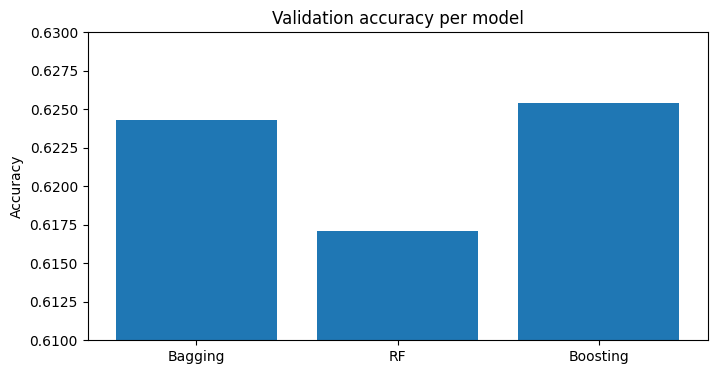

In [20]:
#barchart of the model performances
plt.figure(figsize=(8,4))
plt.bar(accuracy_per_model.keys(), accuracy_per_model.values())
plt.ylabel("Accuracy")
plt.title("Validation accuracy per model")
plt.ylim(0.61, 0.63)  #adjust the scale to make it easier to interpret 
plt.show()


# Conclusion

- The model performs best on the extremes (high and low) and struggles most with the middle tier.

- High-tier predictions are the most trustworthy (highest precision).

- Test performance closely matches validation, suggesting stable performance.

# Explainability 
In this chapter, the best model is explained through various explainability techniques. 
- Permutated feature importance
- Partial dependency plots
- ALE plots
- Shapley Values
- Counterfactuals


### Permutated importance for every model

### Partial dependency plots

Partial dependency plots show how the prediction of the boosted model changes when one feature changes, while taking the average of the other features. 

- We import the pdp package from Sklearn
- We use a subset of features that are highly likely to 

In [ ]:
#from sklearn.inspection import PartialDependenceDisplay

#pdp_features = ["age", "hours-per-week", "education", "workclass", "sex_Male"]
#PartialDependenceDisplay.from_estimator(model, X_train, features, n_jobs=-1, categorical_features=["education", "workclass", "sex_Male"], 
                                       # grid_resolution=20)